***Time-Series Forecasting***


In simple terms data points that are collected sequentially at a regular interval with association over a time period is termed as time-series data. A time-series data having the mean and variance as constant is called stationary time-series. Time-series tend to have a linear relationship between lagged variables and this is called as autocorrelation. Hence a time-series historic data can be modelled to forecast the future data points without involvement of any other independent variables, these types of models are generally known as time-series forecasting. To name some key areas of applications of time-series are sales forecasting, economic forecasting, stock market forecasting etc.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller

# function to calculate MAE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Data Source: O.D. Anderson (1976), in file: data/anderson14, Description: Monthly sales of company X Jan ’65 – May ’71 C. Cahtfield        
df = pd.read_csv('data/TS.csv')
df

,Month,Sales
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36
...,...,...
72,1971-01,628
73,1971-02,308
74,1971-03,324
75,1971-04,248


In [6]:
ts = pd.Series(list(df['Sales']), index=pd.to_datetime(df['Month'],format='%Y-%m'))
ts

Month
1965-01-01    154
1965-02-01     96
1965-03-01     73
1965-04-01     49
1965-05-01     36
             ... 
1971-01-01    628
1971-02-01    308
1971-03-01    324
1971-04-01    248
1971-05-01    272
Length: 77, dtype: int64

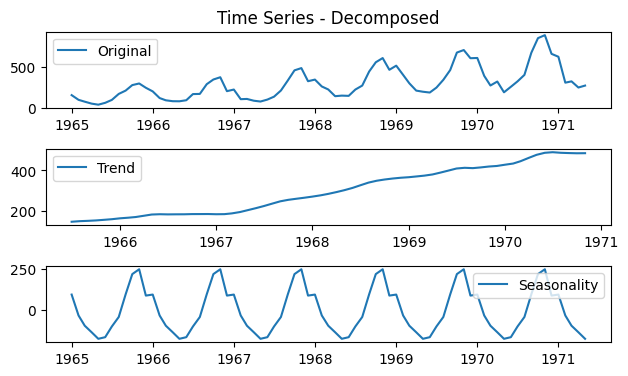

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Time Series - Decomposed')
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

***Checking for stationarity***


Let's split the data into train and test. Since its a time series let's consider 1965 to 1968 for training and reamining for testing.

Business forecasting edition by Hanke and Wichern recommend a minimum of 4 years of data depending on the regularity of data. If the seasonal pattern is regular 3 year data would be sufficient.

In [8]:
s_test = adfuller(ts, autolag='AIC')
# extract p value from test results
print ("p value > 0.05 means data is non-stationary: ", s_test[1])

p value > 0.05 means data is non-stationary:  0.9888894205170052


***Remove stationarity***

In [10]:
# log transform to remove variability
ts_log = np.log(ts)
ts_log.dropna(inplace=True)

s_test = adfuller(ts_log, autolag='AIC')
print ("Log transform stationary check p value: ", s_test[1])

Log transform stationary check p value:  0.7853102124849113


In [11]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

s_test = adfuller(ts_log_diff, autolag='AIC')
print ("First order difference stationary check p value: ", s_test[1])

First order difference stationary check p value:  0.024025392839875384


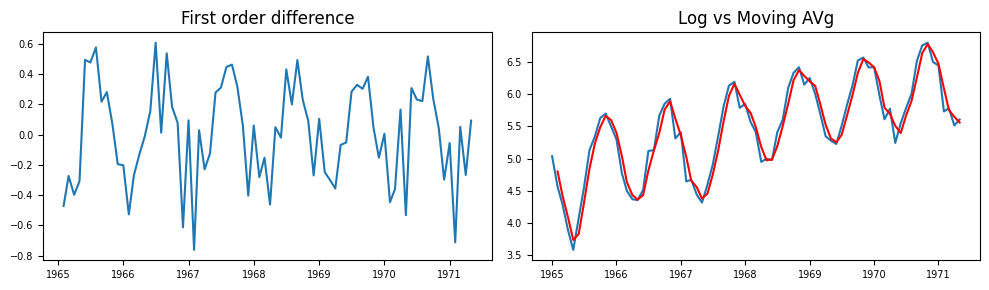

In [13]:
# moving average smoothens the line
moving_avg = ts_log.rolling(window=2).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
ax1.set_title('First order difference')
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
ax1.plot(ts_log_diff)

ax2.plot(ts_log)
ax2.set_title('Log vs Moving AVg')
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.plot(moving_avg, color='red')
plt.tight_layout()

***Autocorrelation test***

Text(0.5, 0, 'Lags')

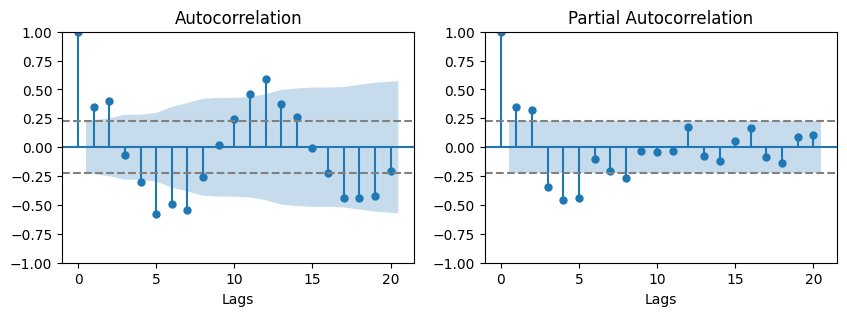

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))

# ACF chart
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=20, ax=ax1)

# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')

# PACF chart
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=20, ax=ax2)

# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

In [18]:
# build model
model = sm.tsa.ARIMA(ts_log, order=(2,0,2))
results_ARIMA = model.fit() 

ts_predict = results_ARIMA.predict()

# Evaluate model
print ("AIC: ", results_ARIMA.aic)
print ("BIC: ", results_ARIMA.bic)

print ("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print ("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

# check autocorrelation
print ("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

AIC:  7.852110626583782
BIC:  21.914943157705885
Mean Absolute Error:  0.1959652611060111
Root Mean Squared Error:  0.23979207707299297
Durbin-Watson statistic : 1.8645734348162075


/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Now lets' increase p to 3 and see if there is any difference in result.

/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC:  9.693491754121876
BIC:  26.100129707097665
Mean Absolute Error:  0.19849817864929184
Root Mean Squared Error:  0.23957593564510182
Durbin-Watson statistic : 1.8243277456011204


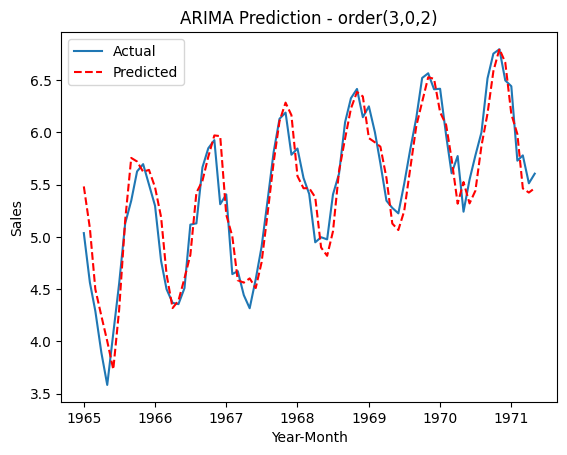

In [19]:
model = sm.tsa.ARIMA(ts_log, order=(3,0,2))
results_ARIMA = model.fit() 

ts_predict = results_ARIMA.predict()
plt.title('ARIMA Prediction - order(3,0,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')

print ("AIC: ", results_ARIMA.aic)
print ("BIC: ", results_ARIMA.bic)

print ("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print ("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

# check autocorrelation
print ("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

***Let's try with one level differencing***

AIC: -33.21455977296741
BIC: -19.230159731249426


/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ValueError: Found input variables with inconsistent numbers of samples: [76, 77]

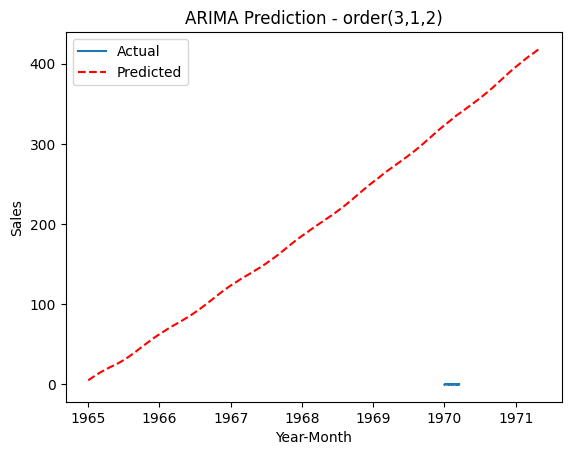

In [26]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming ts_log and ts_log_diff are defined and you have already fitted the model

# Fit ARIMA model
model = sm.tsa.ARIMA(ts_log, order=(3, 1, 2))
results_ARIMA = model.fit()

# Generate predictions
ts_predict = results_ARIMA.predict()

# Correct for the difference
predictions_ARIMA_diff = pd.Series(ts_predict, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Ensure the lengths match
ts_log_diff_values = ts_log_diff.values[:len(ts_predict)]

# Plotting
plt.title('ARIMA Prediction - order(3,1,2)')
plt.plot(ts_log_diff_values, label='Actual')  # Use ts_log_diff_values instead of ts_log_diff.values
plt.plot(predictions_ARIMA_log, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')

# AIC and BIC
print("AIC:", results_ARIMA.aic)
print("BIC:", results_ARIMA.bic)

# MAE and RMSE
mae = mean_absolute_error(ts_log_diff_values, ts_predict.values)
rmse = np.sqrt(mean_squared_error(ts_log_diff_values, ts_predict.values))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Durbin-Watson statistic
dw_statistic = sm.stats.durbin_watson(results_ARIMA.resid.values)
print("Durbin-Watson statistic:", dw_statistic)


***Predicting the future values***

/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kazi/Works/Projects/machine-learning/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


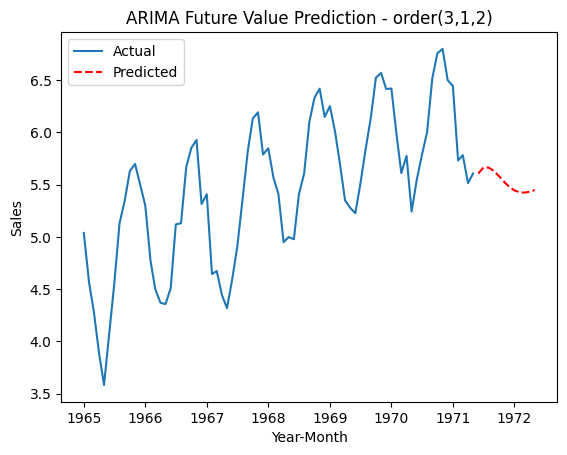

In [28]:
# final model
model = sm.tsa.ARIMA(ts_log, order=(3,0,2))
results_ARIMA = model.fit() 

# predict future values
ts_predict = results_ARIMA.predict('1971-06-01', '1972-05-01')
plt.title('ARIMA Future Value Prediction - order(3,1,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')